# ***Examen práctico parical 3***
### Luis Eduardo Jiménez del Muro - 27/04/2025
---

# **Paqueterías**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.float_format', '{:,.4f}'.format)

plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams['figure.facecolor'] = 'lightgray'

# **Funciones**

## *Funciones para gráficas*

In [2]:
"""
Grafica de calibración
--------------------------------------------------------------------------------------------------------
"""
def calibracion(predicciones, y, bins):
    df_calibracion = pd.DataFrame({
        'predicciones':predicciones,
        'y':y
    })
    df_calibracion['bins'] = pd.qcut(df_calibracion['predicciones'], q=bins, labels=False, duplicates='drop') + 1
    grouped = df_calibracion.groupby('bins').mean()
    auc = roc_auc_score(y_score=predicciones, y_true=y)
    
    # Gráfica
    plt.plot(grouped['predicciones'], grouped['predicciones'], label='Real', color='red', lw=1.5)
    plt.plot(grouped['predicciones'], grouped['y'], label='Modelo', marker='o', color='cadetblue', ms=5, lw=2)
    plt.title(f'Calibración del modelo \n\n$AUC={auc:.4f}$', fontsize=16, fontweight='bold')
    plt.grid(alpha=0.3, ls='--')
    plt.legend(fontsize=12, loc='best')
    plt.show()


"""
Roc Curve
--------------------------------------------------------------------------------------------------------
"""
def roc_curve_graph(probabilidades, y):
    fpr, fpn, scores = roc_curve(y_score=probabilidades, y_true=y)

    plt.title('ROC Curve', fontsize=16, fontweight='bold')
    plt.plot(fpr, fpn, label='Modelo', color='cadetblue', lw=2)
    plt.plot([0, 1], [0, 1], label='Real', color='red', lw=1.5)
    plt.xlabel("1-specificty")
    plt.ylabel("sensitivity")
    plt.legend(loc='best')
    plt.grid(alpha=0.3, ls='--')
    plt.show()

"""
Loss Plot
--------------------------------------------------------------------------------------------------------
"""
def loss_plot(train_loss, test_loss):
    plt.plot(train_loss, label='Train', c='cadetblue')
    plt.plot(test_loss, label='Test', c='red')
    plt.title('Loss', fontweight='bold', fontsize=16)
    plt.xlabel('Iteraciones', fontsize=12)
    plt.ylabel('RMSE', fontsize=12)
    plt.grid(alpha=0.5, ls='--')
    plt.legend(fontsize=12)
    plt.show()


"""
Importance Plot
--------------------------------------------------------------------------------------------------------
"""
def importance_plot(features, importance, type, n_features=10):
    df_importancia = pd.DataFrame({
        'features': features, 
        'importance': importance}).sort_values(by='importance', ascending=True)
    
    plt.barh(df_importancia['features'].tail(n_features), df_importancia['importance'].tail(n_features), 
             color='cadetblue', zorder=2, height=0.4)
    for i, v in enumerate(df_importancia['importance'].tail(n_features)):
        plt.text(v, i, f'{v:.2f}', color='black', fontsize=10)
    plt.title(f'Importancia {type}', fontweight='bold', fontsize=16)
    plt.grid(alpha=0.5, ls='--', axis='x', zorder=0)
    plt.ylabel('Variable', fontsize=14)
    plt.xlabel('Importancia', fontsize=14)
    plt.show()


"""
Plot Resultados
--------------------------------------------------------------------------------------------------------
"""
def plot_results(probabilidades, y, bins):
    calibracion(probabilidades, y, bins)
    roc_curve_graph(probabilidades, y)

## *Funciones de ajuste de modelos y resultados*

In [3]:
"""
Guardar resultados de los modelos
--------------------------------------------------------------------------------------------------------
"""
def guardar_resultado(nombre_modelo, auc, lista_modelos, lista_auc):
    lista_modelos.append(nombre_modelo)
    lista_auc.append(auc)


"""
Ajuste de un árbol de decisión
--------------------------------------------------------------------------------------------------------
"""
def decision_tree(X_train, y_train, X_test, y_test):
    pipeline = Pipeline([
        ('tree', DecisionTreeClassifier()),
    ])
    params = {
        'tree__max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13],
        'tree__min_samples_split': [2, 3, 4, 5, 6, 7],
        'tree__max_features': [None, 'sqrt', 'log2'],
        'tree__criterion': ['gini', 'entropy'],
    }
    grid_tree = GridSearchCV(estimator=pipeline, param_grid=params, cv=5, scoring='roc_auc', n_jobs=-1)
    grid_tree.fit(X_train, y_train)
    best_model = grid_tree.best_estimator_.named_steps['tree']
    predicciones = best_model.predict_proba(X_test)[:, 1]
    auc = roc_auc_score(y_test, predicciones)

    gain = best_model.feature_importances_

    return best_model, predicciones, auc, gain



"""
Ajuste de un Random Forest
--------------------------------------------------------------------------------------------------------
"""
def random_forest(X_train, y_train, X_test, y_test):
    pipeline = Pipeline([
    ('rf', RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=42))
    ])
    params = {
        'rf__max_depth': [1, 2, 5, 8, 10, 15, 30, 50, 100, 200],
        'rf__max_features': ['log2', 'sqrt', len(X_train.columns)*0.7, len(X_train.columns)],
        'rf__min_samples_split': [2, 3, 4, 5, 6, 7]
    }

    rf_grid = GridSearchCV(estimator=pipeline, n_jobs=-1, cv=5, scoring='roc_auc', param_grid=params)
    rf_grid.fit(X_train, y_train)
    best_model = rf_grid.best_estimator_.named_steps['rf']
    predicciones_rf = best_model.predict_proba(X_test)[:, 1]
    auc_rf = roc_auc_score(y_test, predicciones_rf)

    gain = best_model.feature_importances_

    return best_model, predicciones_rf, auc_rf, gain


# **Limpieza de datos**

In [4]:
data = pd.read_csv('data/hr_role.csv')
data.head()

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EnvironmentSatisfaction,Gender,...,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,is_satisfied
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,2,Female,...,80,0,8,0,1,6,4,0,5,True
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,3,Male,...,80,1,10,3,3,10,7,1,7,False
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,4,Male,...,80,0,7,3,3,0,0,0,0,False
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,4,Female,...,80,0,8,3,3,8,7,3,0,False
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,Male,...,80,1,6,3,3,2,2,2,2,False


In [5]:
data.isna().sum()

Age                         0
Attrition                   0
BusinessTravel              0
DailyRate                   0
Department                  0
DistanceFromHome            0
Education                   0
EducationField              0
EnvironmentSatisfaction     0
Gender                      0
HourlyRate                  0
JobInvolvement              0
JobLevel                    0
JobRole                     0
MaritalStatus               0
MonthlyIncome               0
MonthlyRate                 0
NumCompaniesWorked          0
Over18                      0
OverTime                    0
PercentSalaryHike           0
PerformanceRating           0
RelationshipSatisfaction    0
StandardHours               0
StockOptionLevel            0
TotalWorkingYears           0
TrainingTimesLastYear       0
WorkLifeBalance             0
YearsAtCompany              0
YearsInCurrentRole          0
YearsSinceLastPromotion     0
YearsWithCurrManager        0
is_satisfied                0
dtype: int

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 33 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Age                       1470 non-null   int64 
 1   Attrition                 1470 non-null   object
 2   BusinessTravel            1470 non-null   object
 3   DailyRate                 1470 non-null   int64 
 4   Department                1470 non-null   object
 5   DistanceFromHome          1470 non-null   int64 
 6   Education                 1470 non-null   int64 
 7   EducationField            1470 non-null   object
 8   EnvironmentSatisfaction   1470 non-null   int64 
 9   Gender                    1470 non-null   object
 10  HourlyRate                1470 non-null   int64 
 11  JobInvolvement            1470 non-null   int64 
 12  JobLevel                  1470 non-null   int64 
 13  JobRole                   1470 non-null   object
 14  MaritalStatus           

In [7]:
data.nunique()

Age                           43
Attrition                      2
BusinessTravel                 3
DailyRate                    886
Department                     3
DistanceFromHome              29
Education                      5
EducationField                 6
EnvironmentSatisfaction        4
Gender                         2
HourlyRate                    71
JobInvolvement                 4
JobLevel                       5
JobRole                        9
MaritalStatus                  3
MonthlyIncome               1349
MonthlyRate                 1427
NumCompaniesWorked            10
Over18                         1
OverTime                       2
PercentSalaryHike             15
PerformanceRating              2
RelationshipSatisfaction       4
StandardHours                  1
StockOptionLevel               4
TotalWorkingYears             40
TrainingTimesLastYear          7
WorkLifeBalance                4
YearsAtCompany                37
YearsInCurrentRole            19
YearsSince

In [8]:
data_encoded = pd.get_dummies(data)
data_encoded.columns

Index(['Age', 'DailyRate', 'DistanceFromHome', 'Education',
       'EnvironmentSatisfaction', 'HourlyRate', 'JobInvolvement', 'JobLevel',
       'MonthlyIncome', 'MonthlyRate', 'NumCompaniesWorked',
       'PercentSalaryHike', 'PerformanceRating', 'RelationshipSatisfaction',
       'StandardHours', 'StockOptionLevel', 'TotalWorkingYears',
       'TrainingTimesLastYear', 'WorkLifeBalance', 'YearsAtCompany',
       'YearsInCurrentRole', 'YearsSinceLastPromotion', 'YearsWithCurrManager',
       'is_satisfied', 'Attrition_No', 'Attrition_Yes',
       'BusinessTravel_Non-Travel', 'BusinessTravel_Travel_Frequently',
       'BusinessTravel_Travel_Rarely', 'Department_Human Resources',
       'Department_Research & Development', 'Department_Sales',
       'EducationField_Human Resources', 'EducationField_Life Sciences',
       'EducationField_Marketing', 'EducationField_Medical',
       'EducationField_Other', 'EducationField_Technical Degree',
       'Gender_Female', 'Gender_Male', 'JobRole_H

Las variables que digan "Yes" o "No" habría que eliminar una de ellas, para no tener 2 veces la misma variable. En este caso se elminarán las que digan "No". Tambien se hace lo mismo para el Genero, en este caso dejamos a "Male".

In [9]:
data_encoded = data_encoded.drop(columns=['Attrition_No', 'OverTime_No', 'Gender_Female'])

In [10]:
target = 'Attrition'
target_encoded = 'Attrition_Yes'

numeric_features = [col for col in data.columns if data[col].dtype in ['float64'] or data[col].dtype in ['int64']]
categorical_features = [col for col in data.columns if data[col].dtype not in ['float64'] or data[col].dtype not in ['int64']]

## **1. Crea un árbol de max depth 2 y visualizalo, que puedes concluir?**

## *Separar los datos en Train y Test*

In [11]:
X = data_encoded.drop(columns=[target_encoded])
y = data_encoded[target_encoded]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## *Árbol de max depth 2*

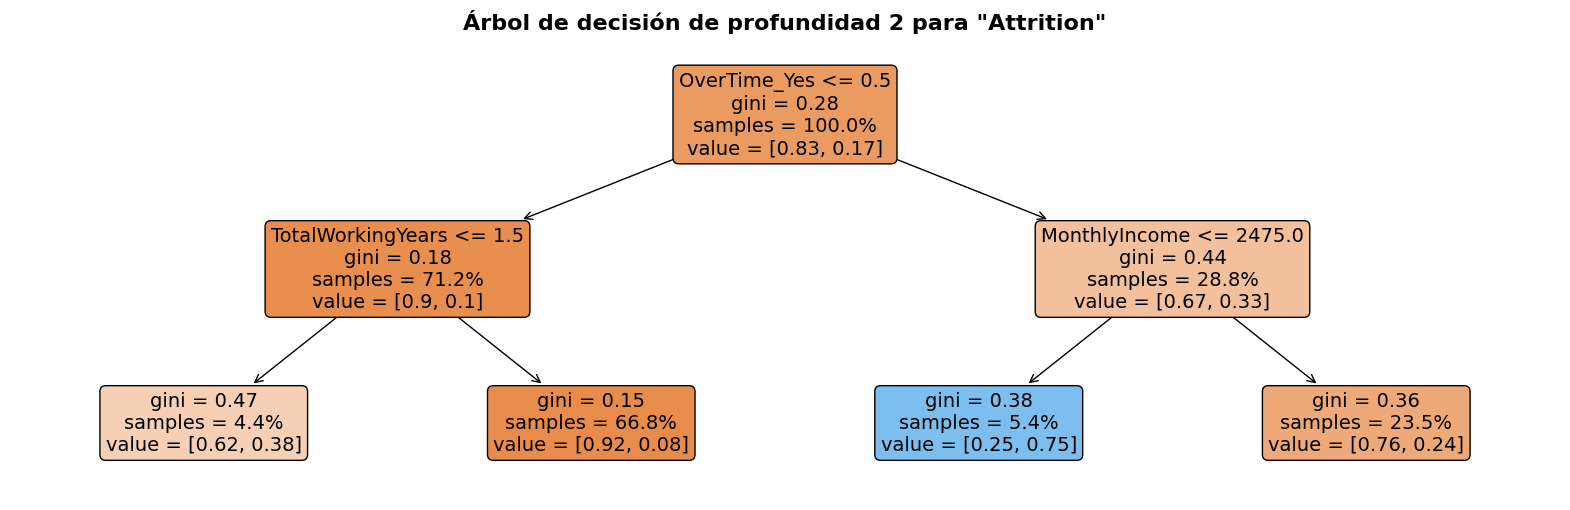

In [12]:
tree_graph = DecisionTreeClassifier(max_depth=2).fit(X_train, y_train)

plt.figure(figsize=(20, 6), facecolor='white')
plot_tree(tree_graph, feature_names=X.columns, filled=True, rounded=True, proportion=True, fontsize=14, precision=2)
plt.title('Árbol de decisión de profundidad 2 para "Attrition"', fontsize=16, fontweight='bold')
plt.show()

## **2- Obtén el mejor árbol posible y dime que tan bueno es el modelo**

## *Inicializar listas para guardar los resultados*

In [13]:
resultados_modelos = []
resultados_auc = []

## *Mejor árbol de decisión*

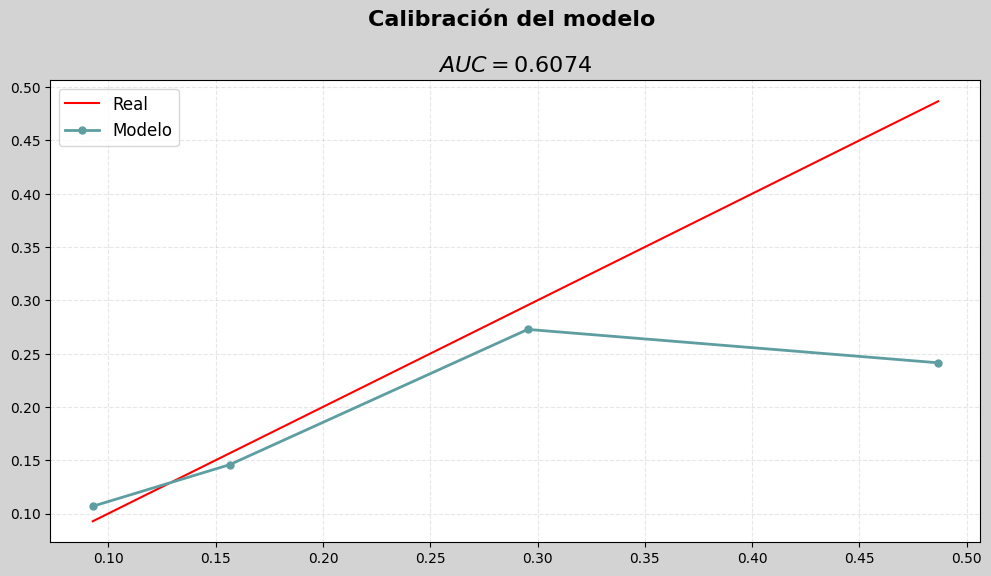

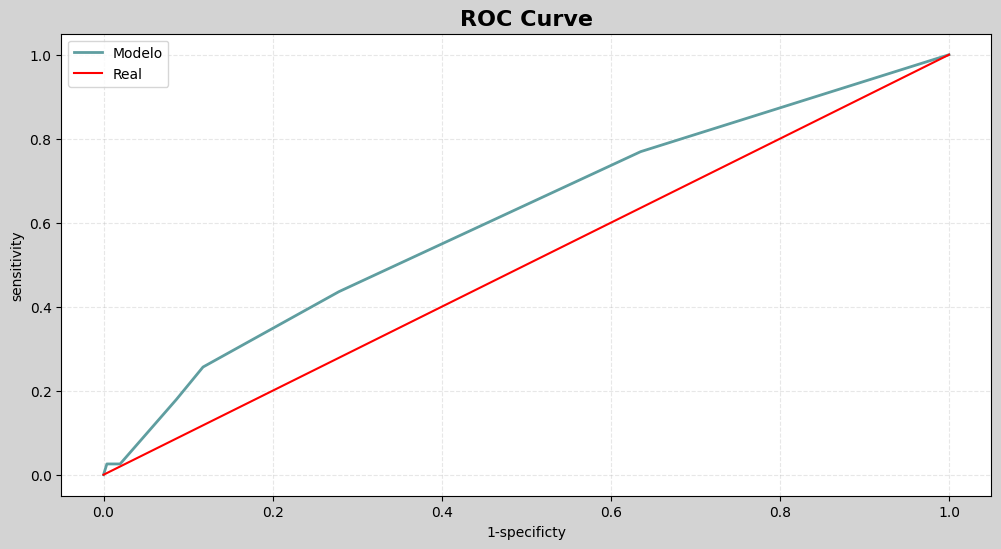

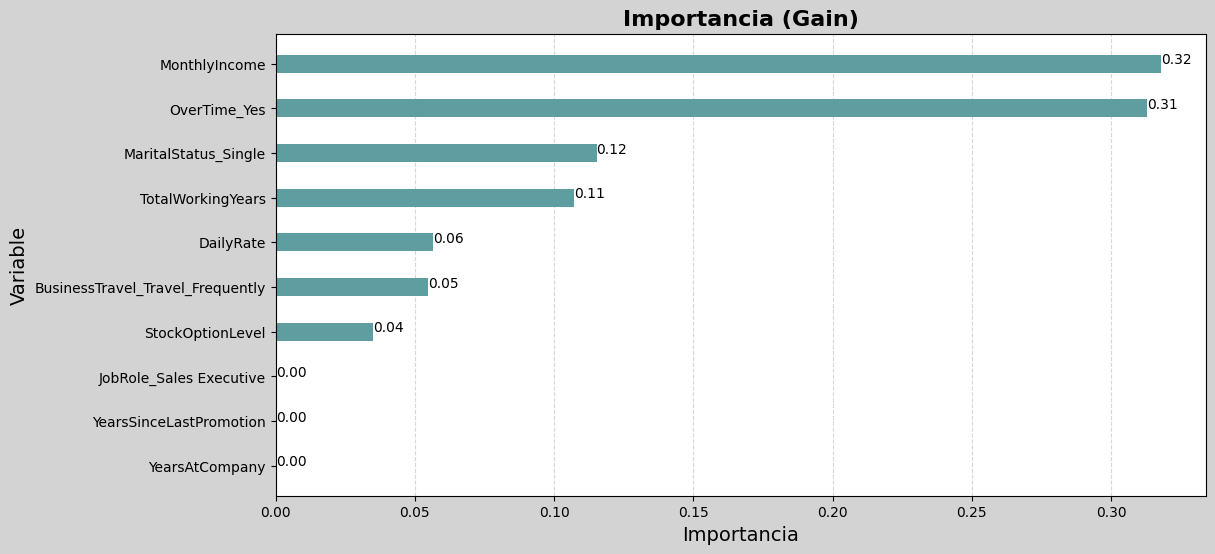

In [14]:
tree, predicciones, auc, gain = decision_tree(X_train, y_train, X_test, y_test)
guardar_resultado('Decision Tree', auc, resultados_modelos, resultados_auc)
plot_results(predicciones, y_test, 10)
importance_plot(X_train.columns, gain, '(Gain)')

## **3. Crea un Random Forest y haz lo mismo, obten el feature importance**

## *Árbol de max depth 2*

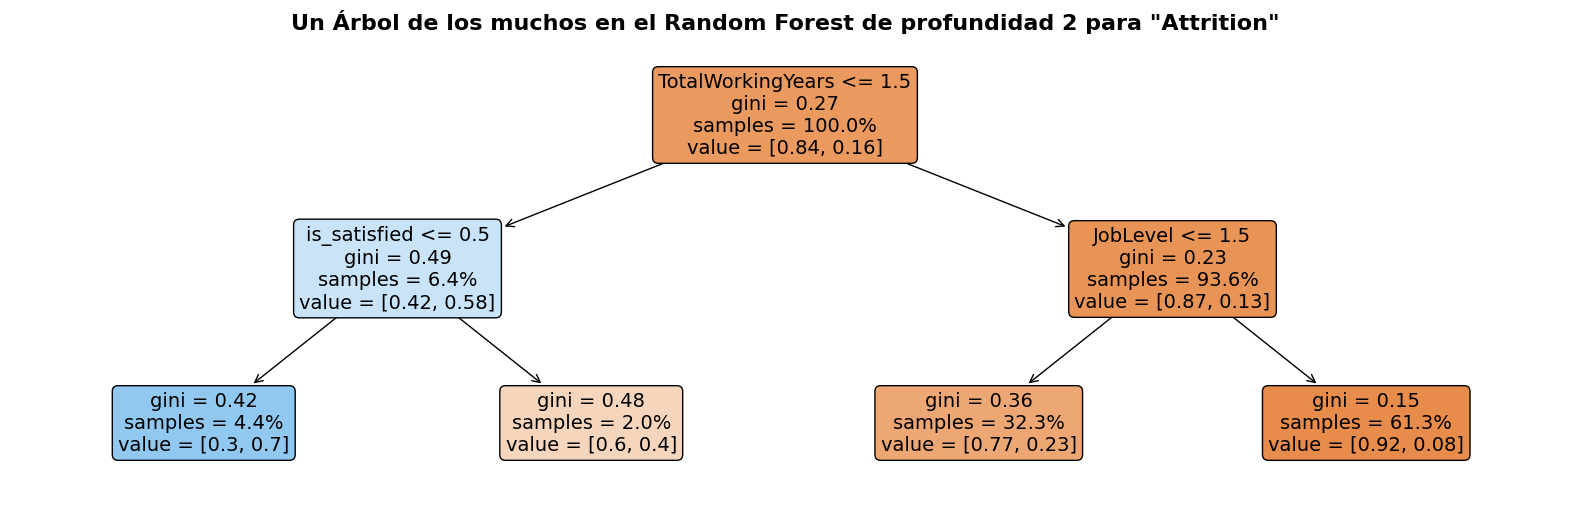

In [15]:
rf_graph = RandomForestClassifier(max_depth=2, n_estimators=1, random_state=42).fit(X_train, y_train)

plt.figure(figsize=(20, 6), facecolor='white')
plot_tree(rf_graph.estimators_[0], feature_names=X.columns, filled=True, rounded=True, proportion=True, fontsize=14, precision=2)
plt.title('Un Árbol de los muchos en el Random Forest de profundidad 2 para "Attrition"', fontsize=16, fontweight='bold')
plt.show()

## *Mejor Random Forest*

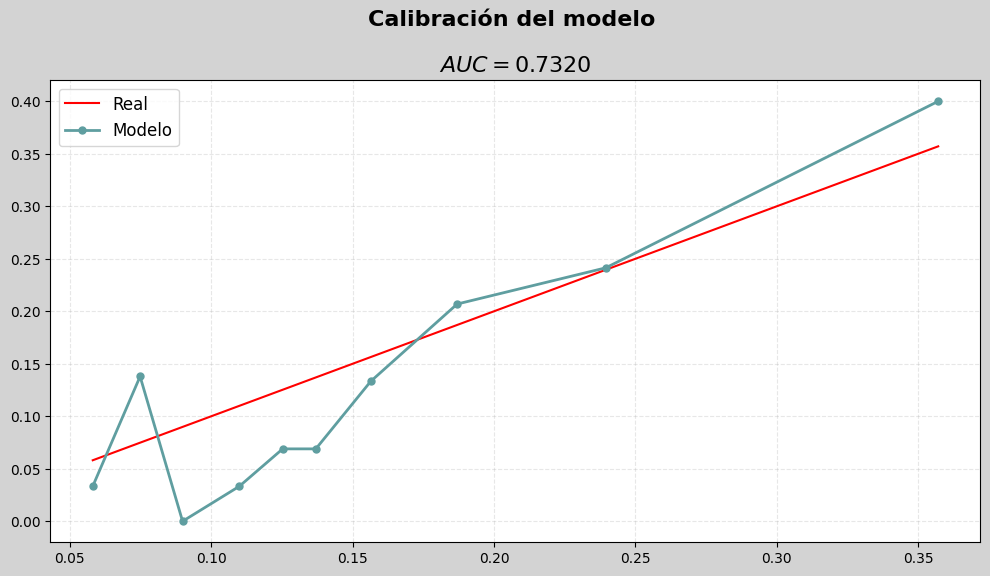

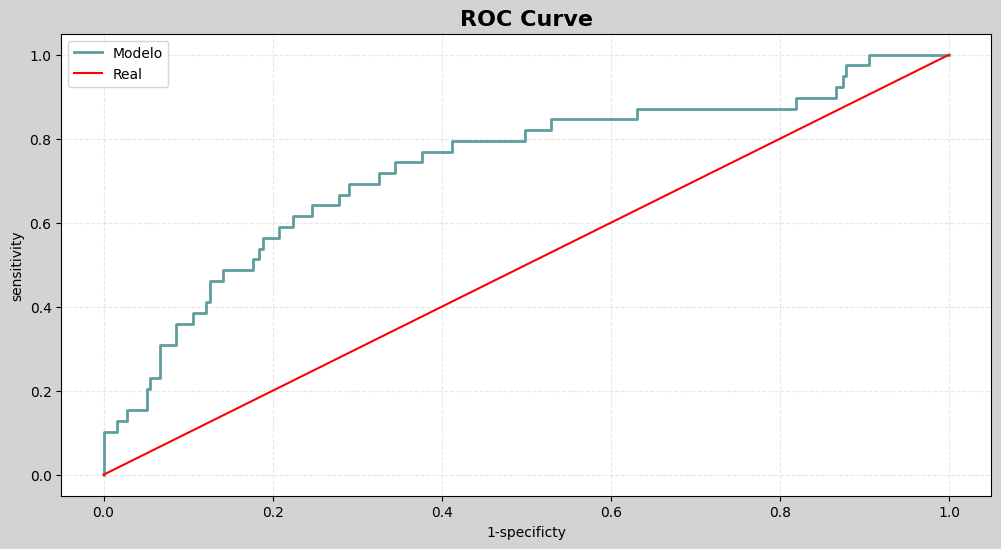

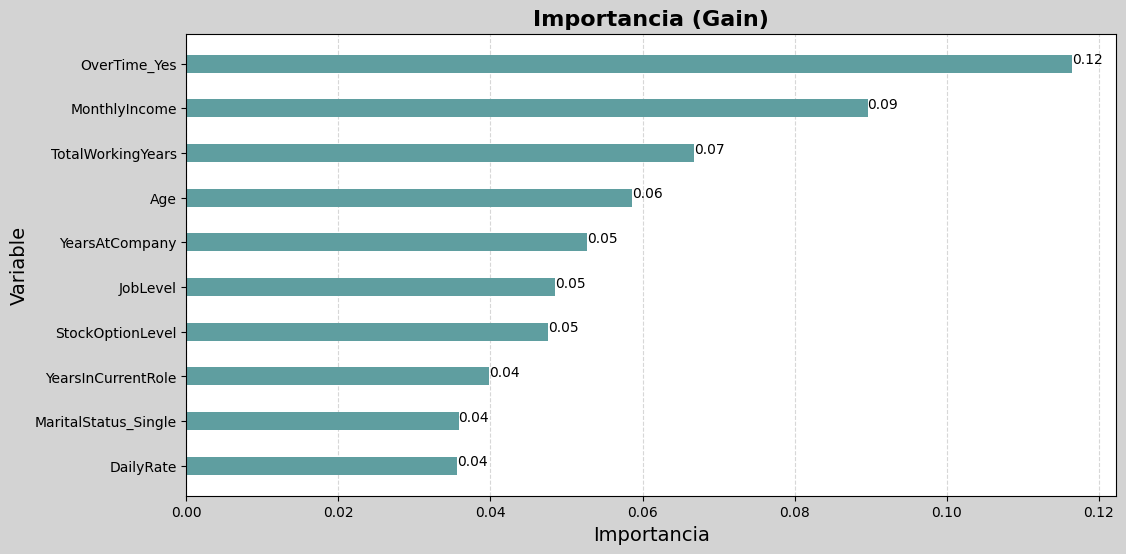

In [18]:
rf, predicciones, auc, gain = random_forest(X_train, y_train, X_test, y_test)
guardar_resultado('Random Forest', auc, resultados_modelos, resultados_auc)
plot_results(predicciones, y_test, 10)
importance_plot(X_train.columns, gain, '(Gain)')

## **4- Repite el proceso con xgboost**

In [29]:
"""
XGBoost
--------------------------------------------------------------------------------------------------------
"""
def xgboost(X_train, y_train, X_test, y_test):
    params = {
        'n_estimators': [100_000],
        'max_depth': [1, 2, 5, 10],
        'learning_rate': [0.01, 0.05, 0.1],
        'reg_lambda': [0.01, 0.1, 1],
        'tree_method': ['hist'],
        'eval_metric': ['auc']
    }

    model = XGBClassifier(eval_metric='auc', n_jobs=-1, random_state=42,early_stopping_rounds=20)

    xgb_grid = GridSearchCV(estimator=model, n_jobs=-1, cv=5, scoring='roc_auc', param_grid=params)
    xgb_grid.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], verbose=0)

    best_model = xgb_grid.best_estimator_
    predicciones = best_model.predict_proba(X_test)[:, 1]
    auc = roc_auc_score(y_test, predicciones)

    weight = model.get_booster().get_score(importance_type='weight')
    gain = model.get_booster().get_score(importance_type='gain')

    return best_model, predicciones, auc, weight, gain

xgboost_model, predicciones, auc, weight, gain = xgboost(X_train, y_train, X_test, y_test)
guardar_resultado('XGBoost', auc, resultados_modelos, resultados_auc)
plot_results(predicciones, y_test, 10)
importance_plot(X_train.columns, gain, '(Gain)')
importance_plot(X_train.columns, weight, '(Weight)')

NotFittedError: need to call fit or load_model beforehand